# Target gene and neighbouring gene expression

1. Run through the 10x Cellranger pipeline and velocyto for single cell RNAseq quatification and using (2) guides quantifiction. all found in the cellranger files folder **bash**
2.  Guide Calling for dual guide. Use repogle method to take molecule.h5 generated by cellranger and py to run through repogle version of guide calling or use cellranger_guidecalling.ipynb for Direct Capture Perturb-Seq dual guide. Formed guide-specific lists of cells.
3. Pseudobulk analysis.
    A. Seperation of guide-specific fastq files. **bash**
    B. Whippet pseudobulk for transcript specific analysis, post UMI deduplication.  **bash**
    C. Transcript quality control. **R**
    D. Whippet result visualisation.
4. Normalisation of adata object and E-distance of KD
5. **Check gene and neighboring gene expression**
6. Create individual umaps per gene of interest 
    A. UMAPs 
    B. Rand Index score
7. Cell phase assignment model from FUCCI-matched single cell paper (GSE146773_)
8. Differential Expression analysis.
    A. Find the shared P1 and P2 genes. 
    B. Check the shared P1 and P2 across different protospacers with the same A/B and C/D.
9.  CNV Score & Numbat to quantify and Velocity quantification with loom file
10. ESR1-specific analysis from proliferation analysis to rt-qpcr
11.  Spectra analysis and visualisation for pathway enrichment



This notebook, 5_genekd_neighbouring_gene_expression.ipynb, focuses on the specificity and quality control of the CRISPR interference (CRISPRi) perturbations. Specifically, it ensures that the observed transcriptomic changes are caused by the targeted gene knockdown and not by accidental silencing of nearby "neighbouring" genes.



Here is a breakdown of the computational steps and biological significance of this notebook:

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2
#general
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import hdf5plugin
import warnings
#form a location
loc="alt-prom-crispr-fiveprime/"

import seaborn as sns
from tqdm.notebook import tqdm
import scperturb
import sys
sys.path.append(loc+'scripts/')
from apu_analysis import *
import scperturb
import infercnvpy as cnv
from apu_analysis.cell_import import CellPopulation
from IPython.display import clear_output
pd.options.display.float_format = '{:.4f}'.format
import matplotlib.pyplot as plt

#for this python
from scipy.special import rel_entr
import sklearn.cluster as cluster
import umap
from scipy import stats
from scipy.stats import bootstrap
from statsmodels.stats.multitest import multipletests
from numpy import reshape
from numpy import array
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
# from statannotations.Annotator import Annotator


# Taken from: 
# Adamson, B.A., Norman, T.M., *et al.* "A multiplexed CRISPR screening platform enables systematic dissection of the unfolded protein response", *Cell*, 2016.
# My experiment deals with two KDs- one of the MP, one of the AP using two guides. Positve controls include GINS1 ect. This is a combnatorial KD double for the same gene. No treatments were used

# colours using garvan 
color1 ='#4d00c7'
palecolor1="#b366ff"
color2= '#da3c07'
palecolor2="#ff8954"
color3='#05d3d3'
color4='#c6c7c5'
color4="#434541"
color5="#eb31e1"
color6="#3175eb"
color7="#a7eb31"
color8="#b366ff"
color9="#ff8954"
color10="#35c9d4"

#use viridis
# color1="#fde725"
# color2="#7ad151"
# color3="#22a884"
# color4="#2a788e"
# color5="#2a788e"
# color6='#440154'

# # Set the color for the histogram
color1 ='#4d00c7'
palecolor1="#b366ff"
color2= '#da3c07'
palecolor2="#ff8954"
color3='#05d3d3'
color4='#c6c7c5'
color5='black'

# Set the color for the histogram
color1 ='#4d00c7'
palecolor1="#b366ff"
color2= '#da3c07'
palecolor2="#ff8954"
color3='#05d3d3'
color4='#c6c7c5'
color5='black'

# # Create the color palette
# Create the color palette
palette = sns.color_palette([palecolor1,palecolor2])
palette2 = sns.color_palette([color1, color2, color3, color4,color5,color6 ,color7])
new_palette = sns.color_palette([color1, color2,color3, color2,color1, color2,color1, color2,color1, color2,color1, color2, color3, color4])


warnings.filterwarnings('ignore')

print("Scanpy", sc.__version__)
%matplotlib inline

/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Scanpy 1.10.3


In [2]:
%%capture
##load the adata frame
adata = ad.read_h5ad(loc+"files/adata_normalised.h5ad")
#set adata.X as log1p
adata.X = adata.layers["log1p"]

In [3]:
#gene list import
gene_list = pd.read_csv('
            sep='\t',
            header=None,
            names=['chr', 'source', 'type', 'start', 'end', 'null1', 'orientation', 'null2', 'notes'])

gene_list = gene_list[['chr', 'source', 'type', 'start', 'end', 'orientation', 'notes']]
gene_list['gene_id'] = gene_list['notes'].map(lambda x: x.split('"')[1])

gene_list["notes"][0]

gene_list['gene_name'] = gene_list['notes'].map(lambda x: x.split('"')[7])
gene_list['gene_type'] = gene_list['notes'].map(lambda x: x.split('"')[5])

protein_gene_list = gene_list[gene_list['gene_type'] == "protein_coding"]
protein_gene_list = protein_gene_list[protein_gene_list["gene_name"].isin(list(adata.var_names))] ##subseet for the genes found in the signle cell matrix 
protein_gene_list.reset_index(inplace=True,drop=True)
genes_interest=adata.obs["perturbation"][~adata.obs["perturbation"].isin(["non-targeting"])].drop_duplicates() #create a list of genes to subset



In [4]:
%%capture
n =10 
output=list()
for goi in genes_interest:
    print(goi)
    subset = get_subset(gene_list, goi)
    if ((subset.empty) | (goi=="UPF3B") | (goi=="STAG2")):
        print(goi,"not found")
        continue
    else:
        if check_promoters(adata, goi):
            for promoter in ["MP","AP"]:
                print(goi,"found")
                cell_barcodes = get_cell_barcodes_goi(adata, goi, promoter)
                neighboring_genes = get_neighboring_genes(protein_gene_list, goi, n, subset)
                neighborhood = get_neighborhood(adata, cell_barcodes, neighboring_genes)
                control_neighborhood = get_control_neighborhood(adata, neighboring_genes)
                output += perform_ztest(neighborhood, control_neighborhood, neighboring_genes, goi, promoter, n)
output_df = pd.DataFrame(output, columns=['gene', 'promoter','neighbouring_gene', 'position','distance',"samechr" ,'z_test', 'z_test_pvalue'])

Neighbouring Gene Identification
CRISPRi uses a KRAB domain to silence promoters, but this silencing can sometimes spread to adjacent genomic regions.


What is happening: The code uses genomic coordinates to identify all genes located within a specific window (e.g., the "next-door" genes) of the 42 targeted candidates.



Purpose: To create a reference set of genes that should not be affected if the CRISPRi targeting is truly promoter-specific.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


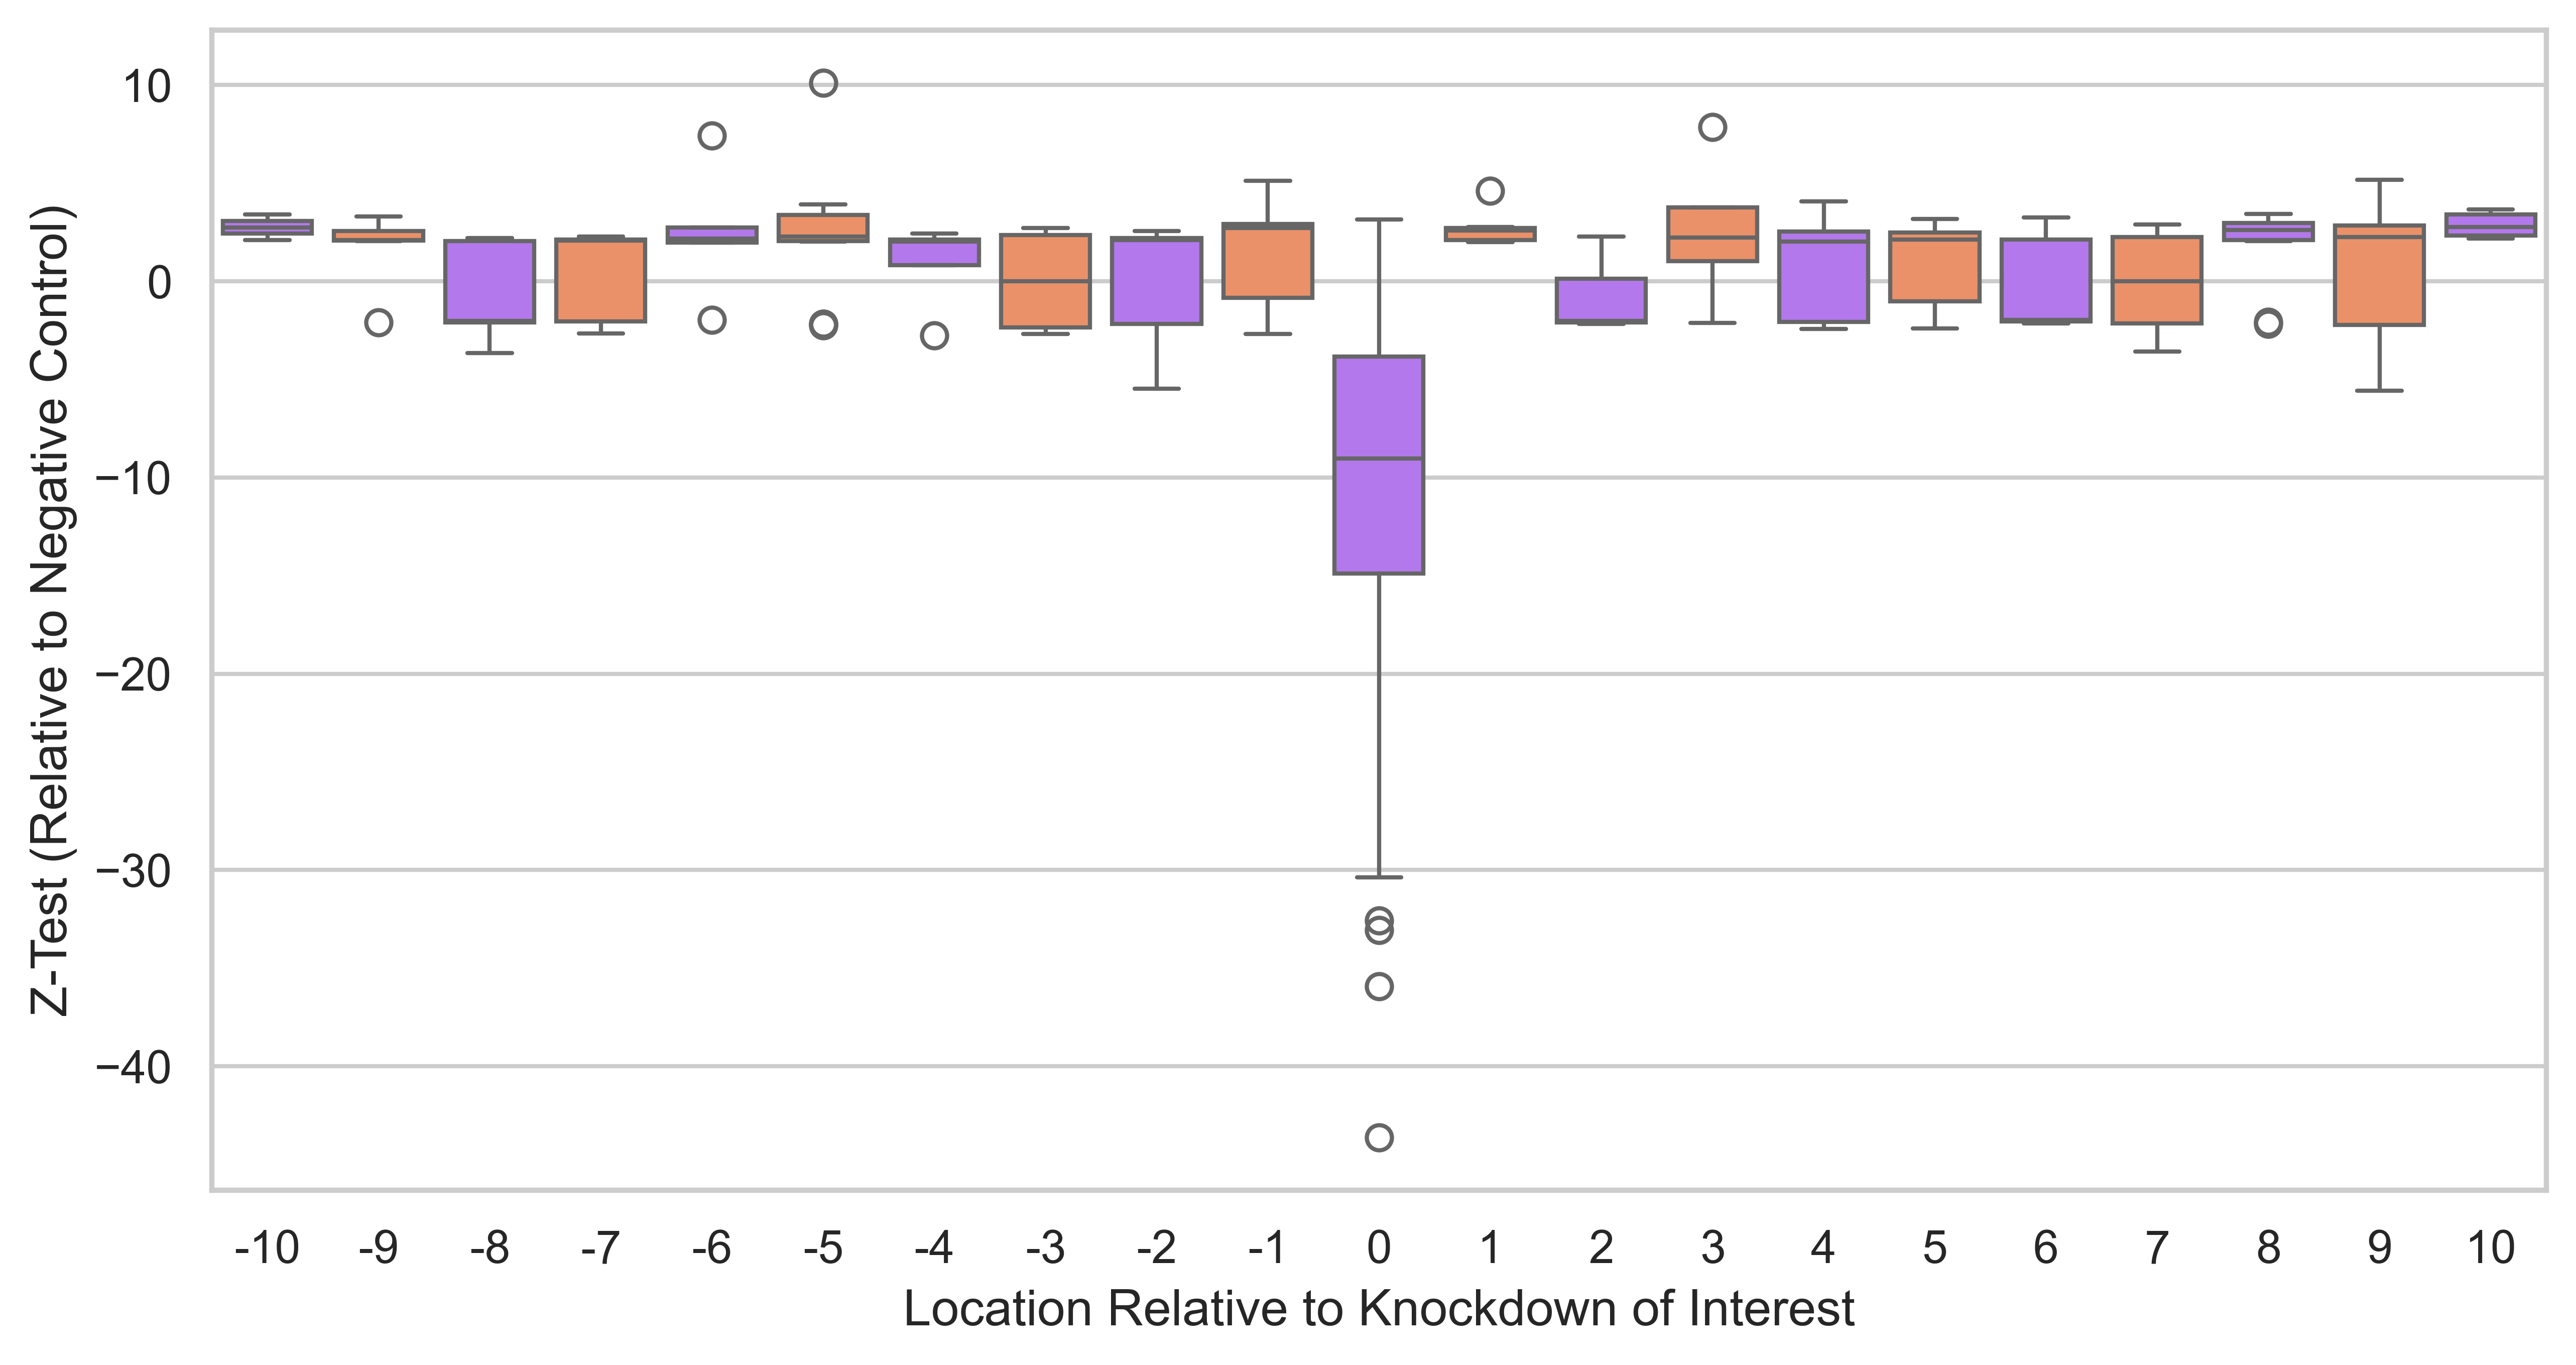

In [5]:
# Create a figure with two subplots
#set style
sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 1,figsize=(10, 5), dpi= 600, facecolor='none')
# order=["-5","-4","-3","-2","-1","0","1","2","3","4","5"]
sns.boxplot(data=output_df[output_df["z_test_pvalue"] < 0.05], y="z_test", x="position", ax=ax, hue="position",  palette=palette)
# , order=order)
plt.ylabel("Z-Test (Relative to Negative Control)")
plt.xlabel("Location Relative to Knockdown of Interest")
#tremove the legend
plt.legend([],[], frameon=False)
plt.savefig(loc+"figures/5_gene_kd_neighboring/distance_overall.pdf", format="pdf", bbox_inches="tight")
sns.set(font_scale=0.8)


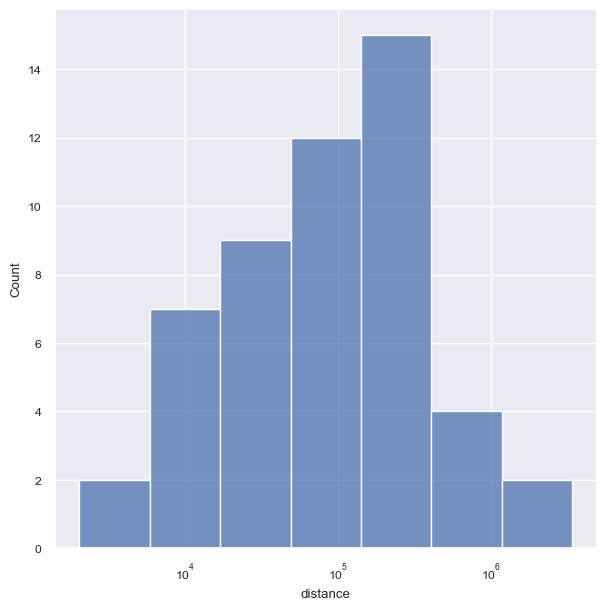

In [6]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log")

sns.histplot(output_df["distance"][(output_df["position"]==1) &(output_df["promoter"]=="MP") ].abs(),ax=ax )
# save figujre
plt.savefig(loc+"figures/5_gene_kd_neighboring/distance_hist.pdf", format="pdf", bbox_inches="tight")

The notebook performs a rigorous statistical comparison between "on-target" effects and "off-target" effects on genomic neighbours.


Differential Expression: It compares the expression of the targeted gene and its neighbours in perturbed cells versus non-targeting control (NTC) cells using z-tests.



Result Found: The analysis shows that while the targeted genes (e.g., ESR1) show significant knockdown, their neighbouring genes remain stably expressed. This confirms that the Isoform-Specific Perturb-Seq approach has high spatial resolution and does not cause widespread collateral silencing in the genome.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


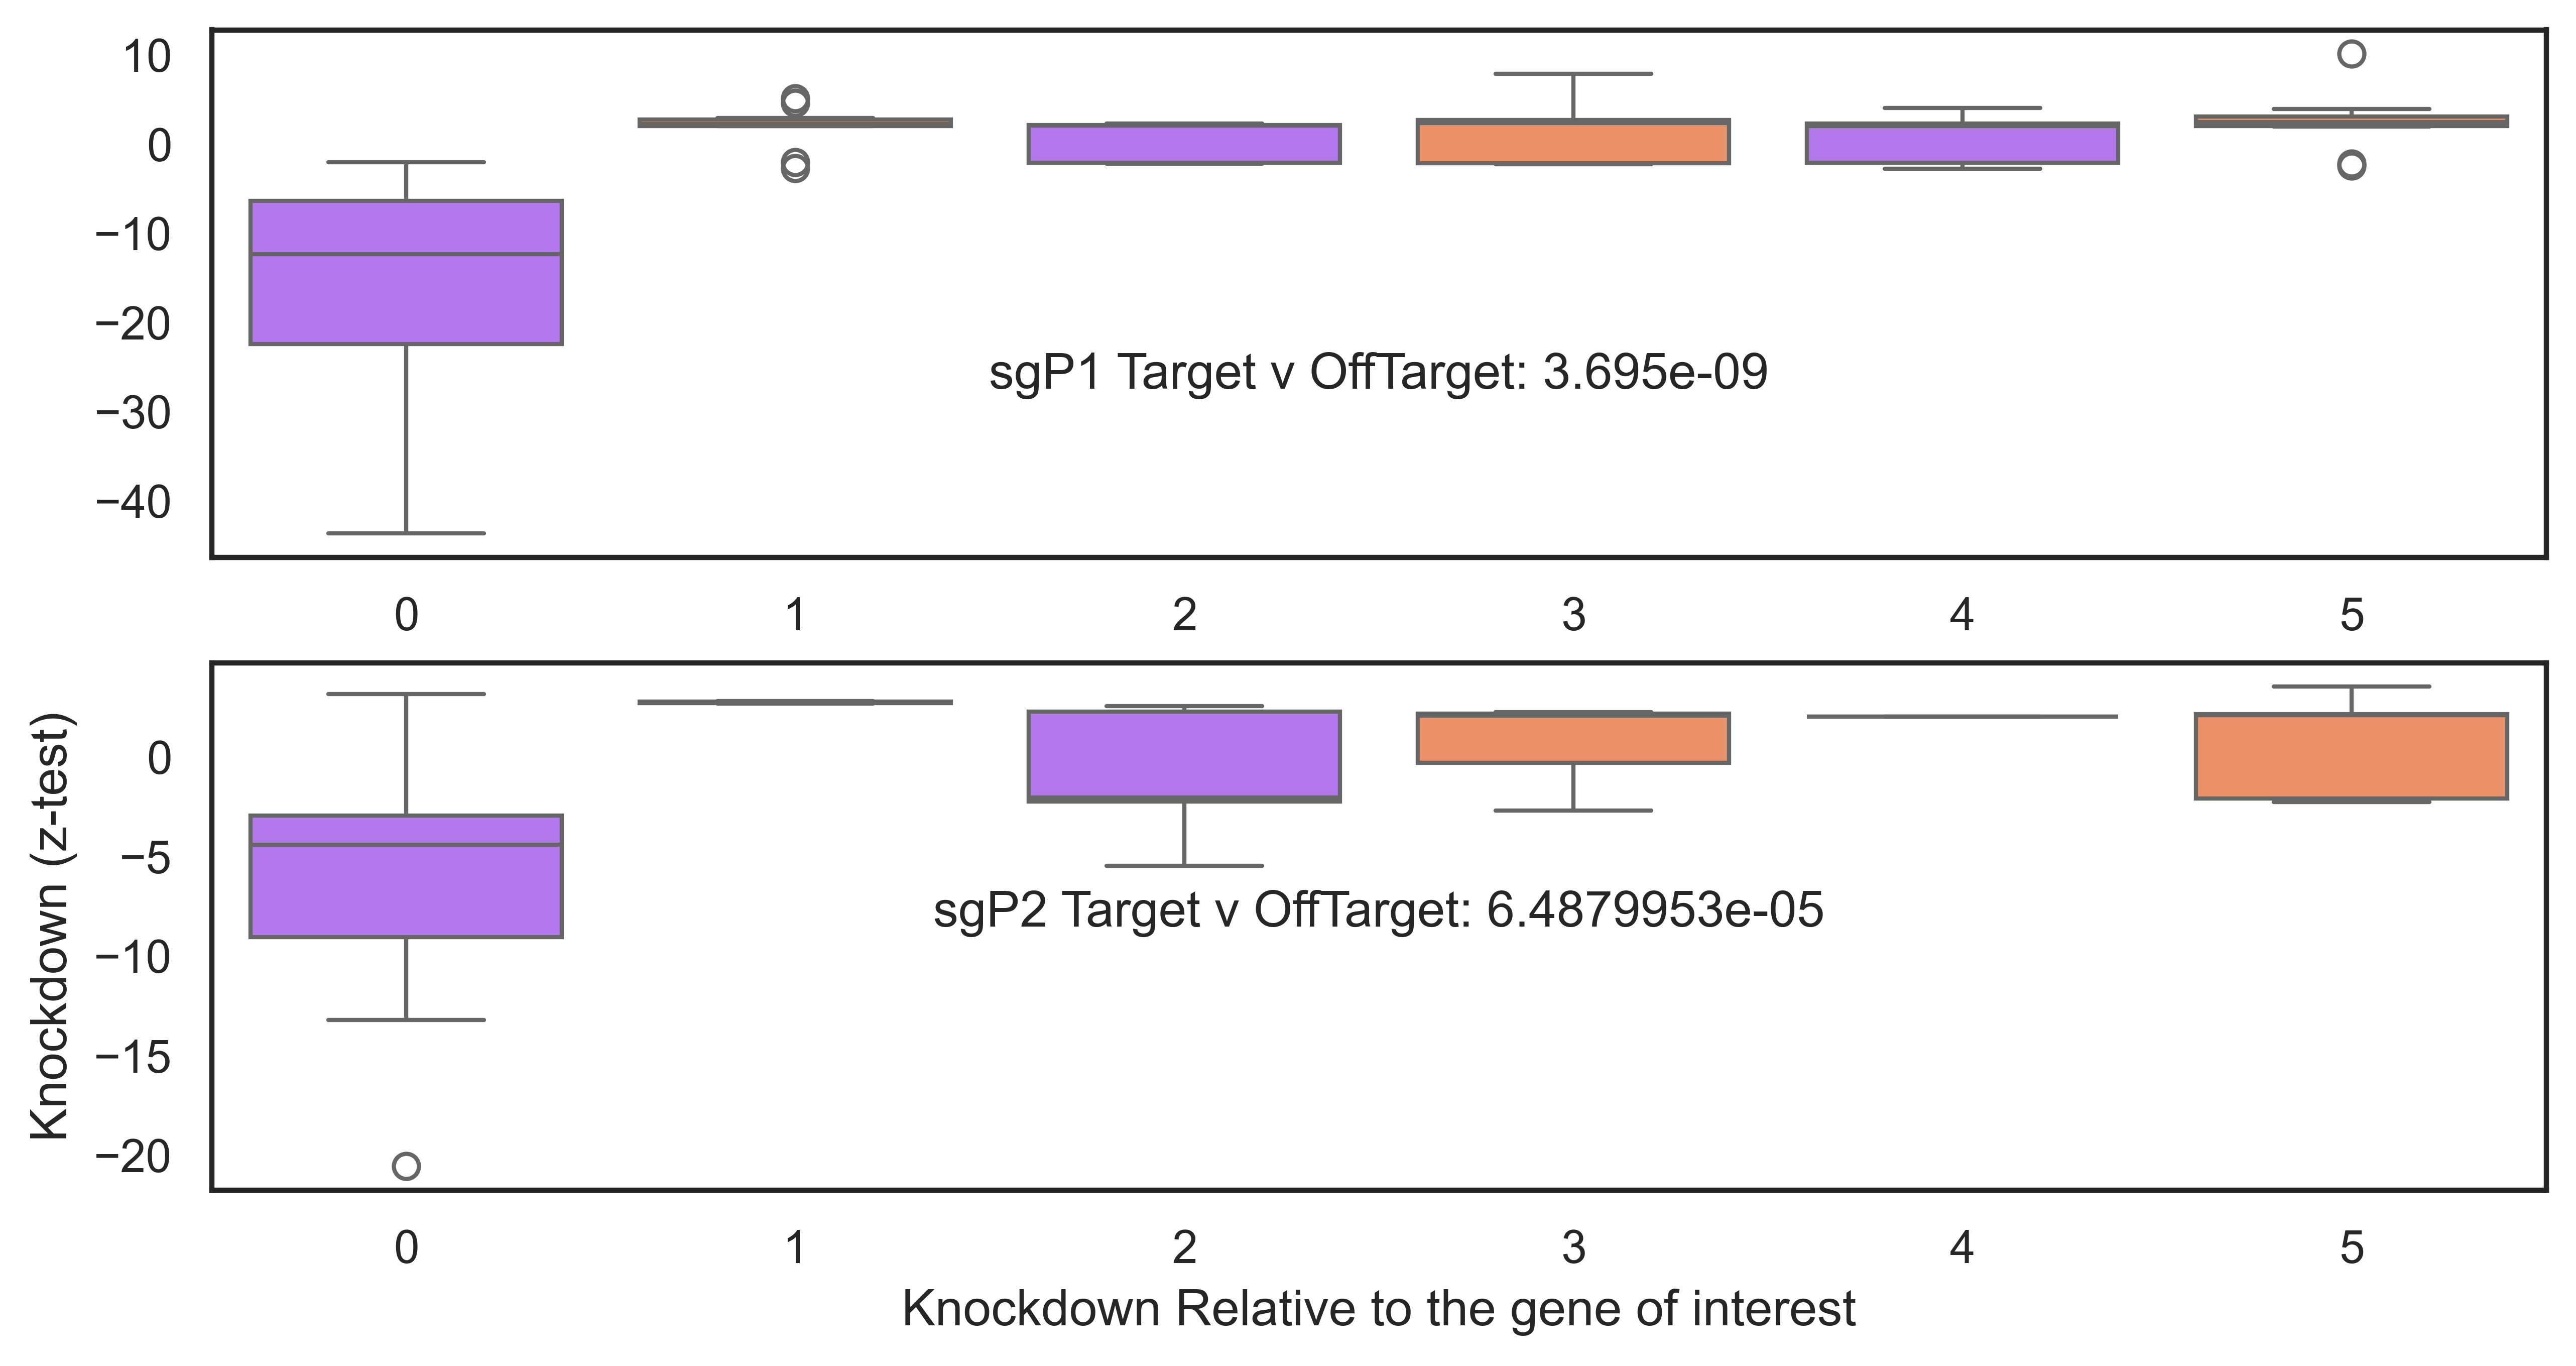

In [8]:

#get corrrelation between
output_df_zero = output_df[output_df["position"]==0]
output_df_zero=pd.pivot_table(output_df, values=['z_test'], index=['gene','position'], columns=['promoter'])
output_df_zero.reset_index(inplace=True)
output_df_zero['notzero']=np.where(output_df_zero["position"]==0,True,False)

#correlation between MP and AP KD
statistics_ttest_1=stats.ttest_ind(output_df_zero.loc[output_df_zero['notzero']==True,('z_test', 'MP')].values,output_df_zero.loc[output_df_zero['notzero']==False,('z_test', 'MP')].values , equal_var=False)
statistics_ttest_2=stats.ttest_ind(output_df_zero.loc[output_df_zero['notzero']==True,('z_test', 'AP')].values,output_df_zero.loc[output_df_zero['notzero']==False,('z_test', 'AP')].values , equal_var=False)



# Create a figure with two subplots
sns.set(style="white")
fig, ax = plt.subplots(2, figsize=(10, 5), dpi= 600, facecolor='none')
sns.set(font_scale=0.8)
order=["0","1","2","3","4","5"]
output_df_sig=output_df[output_df["z_test_pvalue"]<0.05]
output_df_sig["pos_position"]=np.abs(output_df_sig["position"])
g1=sns.boxplot(data=output_df_sig[(output_df_sig["promoter"]=="MP")], y="z_test", x="pos_position", hue="pos_position", ax=ax[0], palette=palette, order=order)
g2=sns.boxplot(data=output_df_sig[(output_df_sig["promoter"]=="AP")], y="z_test", x="pos_position", hue="pos_position",ax=ax[1], palette=palette, order=order)
#remove the legend from each plot
ax[0].legend([],[], frameon=False)
ax[1].legend([],[], frameon=False)
plt.text(2.5,+18.5, "sgP1 Target v OffTarget: "+str( statistics_ttest_1.pvalue.round(12)), fontsize=12, ha='center')
plt.text(2.5,-8.5, "sgP2 Target v OffTarget: "+str( statistics_ttest_2.pvalue.round(12)), fontsize=12, ha='center')

#remove the xlabel from 
ax[0].set_xlabel("")
ax[1].set_xlabel("")
#same for ylabel
ax[0].set_ylabel("")
ax[1].set_ylabel("")
#put the text 
#add the labels
plt.ylabel("Knockdown (z-test)")
plt.xlabel("Knockdown Relative to the gene of interest")
plt.savefig(loc+"figures/5_gene_kd_neighboring/distance_promoter_spec.pdf", format="pdf", bbox_inches="tight")


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


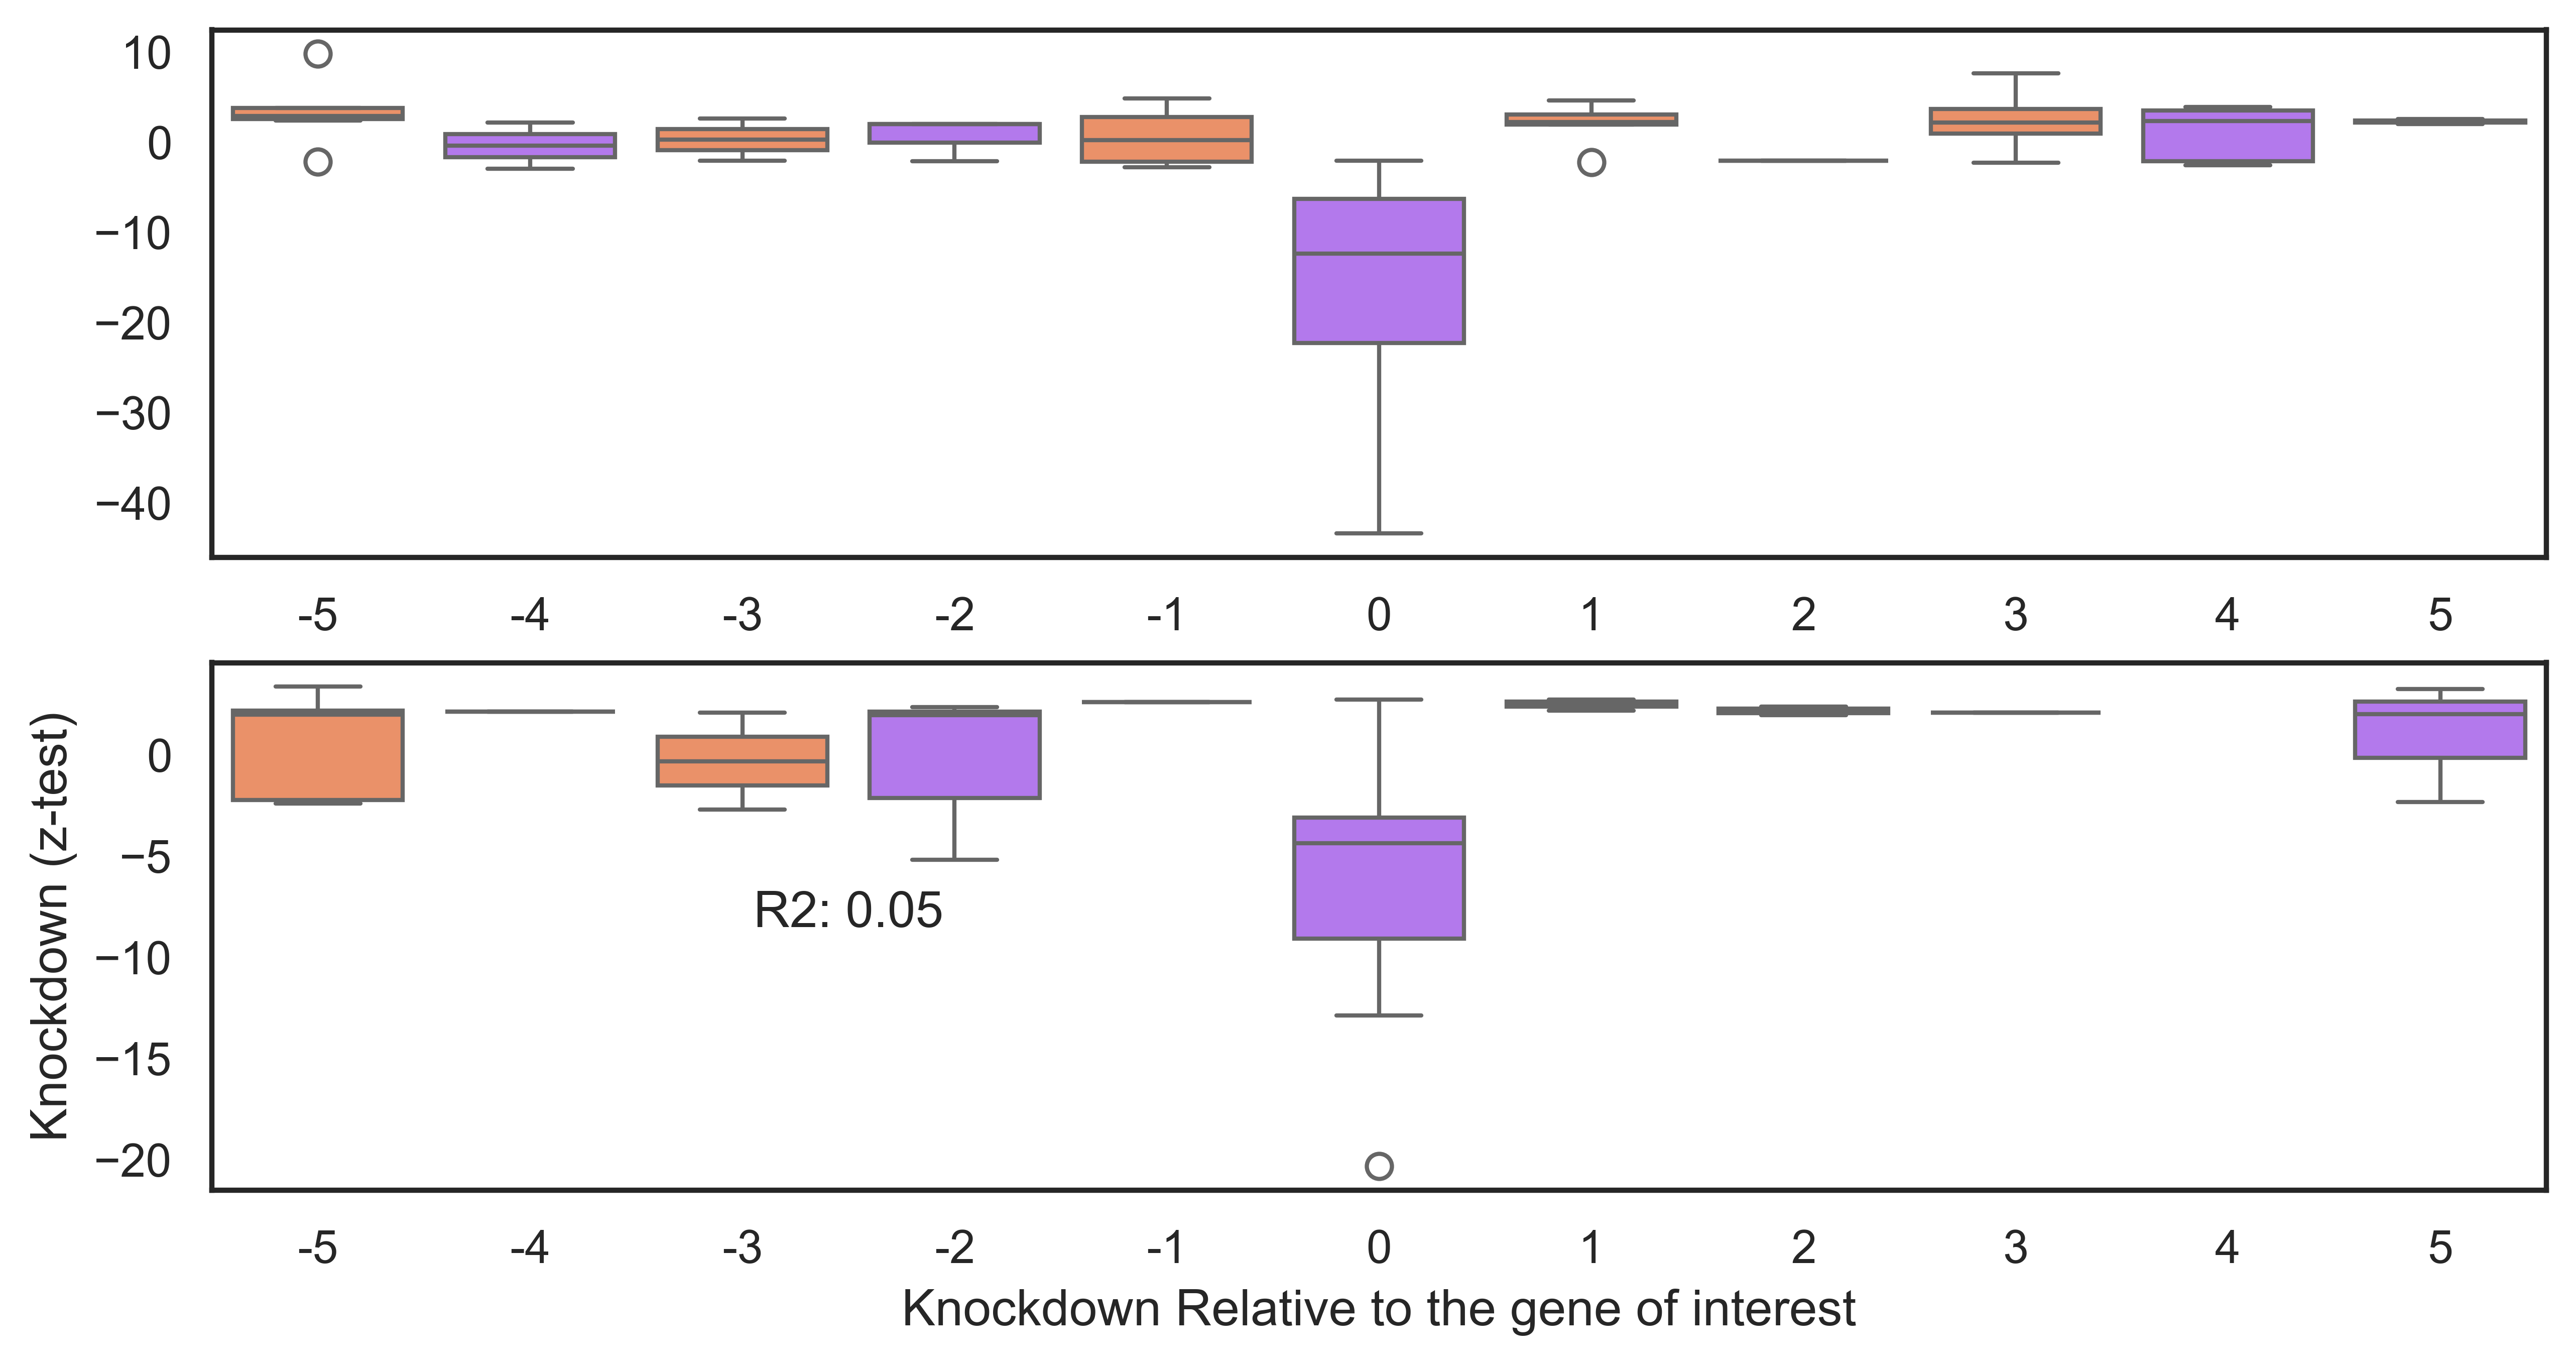

In [79]:
#get corrrelation between
output_df_zero = output_df[output_df["position"]==0]
output_df_zero=pd.pivot_table(output_df[output_df["z_test_pvalue"]<0.05], values=['z_test'], index=['gene','position'], columns=['promoter'])
#correlation between MP and AP KD
# statistics_ttest=stats.ttest_ind(, , equal_var=False)
# put the statistics between
output_df_zero[('z_test', 'MP')].corr(output_df_zero[('z_test', 'AP')])
#remove warnings output
# Create a figure with two subplots
sns.set(style="white")
fig, ax = plt.subplots(2, figsize=(10, 5), dpi= 600, facecolor='none')
sns.set(font_scale=0.8)
order=["-5","-4","-3","-2","-1","0","1","2","3","4","5"]
#split for AP and MP into two plots
plt.text(2.5,-8.5, "R2: "+str(output_df_zero[('z_test', 'MP')].corr(output_df_zero[('z_test', 'AP')]).round(2) ), fontsize=12, ha='center')
#melt the dataframe output_df_zero so z_test for MP and AP
#put texct on the plot
output_df_sig=output_df[output_df["z_test_pvalue"]<0.05]
g1=sns.boxplot(data=output_df_sig[(output_df_sig["promoter"]=="MP")], y="z_test", x="position", hue="position", ax=ax[0], palette=palette, order=order)
g2=sns.boxplot(data=output_df_sig[(output_df_sig["promoter"]=="AP")], y="z_test", x="position", hue="position",ax=ax[1], palette=palette, order=order)
#remove the legend from each plot
ax[0].legend([],[], frameon=False)
ax[1].legend([],[], frameon=False)
#remove the xlabel from 
ax[0].set_xlabel("")
ax[1].set_xlabel("")
#same for ylabel
ax[0].set_ylabel("")
ax[1].set_ylabel("")
#put the text 
#add the labels
plt.ylabel("Knockdown (z-test)")
plt.xlabel("Knockdown Relative to the gene of interest")
plt.savefig(loc+"figures/5_gene_kd_neighboring/distance_promoter_spec.pdf", format="pdf", bbox_inches="tight")
#check the number A, B, C and D for each of the gene_targets
adata.obs["protospacer_number"]=adata.obs["guide_assignment"].str.split("_").str.get(-1)
# adata.obs["protospacer_number"].value_counts()
%%capture
output= [process_gene(adata, goi, geneset="transcriptome") for goi in genes_interest if process_gene(adata, goi,geneset="transcriptome") is not None]

output_df = pd.DataFrame(output, columns=['gene', 'Protospacer_P1_1', 'pvalue_P1_1','Random_Guide_P1_1', 'pvalue_other_P1_1','Protospacer_P1_2', 'pvalue_P1_2','Random_Guide_P1_2', 'pvalue_other_P1_2','Protospacer_P2_1', 'pvalue_P2_1','Random_Guide_P2_1', 'pvalue_other_P2_1','Protospacer_P2_2', 'pvalue_P2_2', 'Random_Guide_P2_2', 'pvalue_other_P2_2'])
correlation=output_df[["Protospacer_P1_1","Protospacer_P1_2","Random_Guide_P1_1","Random_Guide_P1_2","Protospacer_P2_1","Protospacer_P2_2","Random_Guide_P2_1","Random_Guide_P2_2"]].corr()
# correlation=output_df[["Protospacer_P1_1","Protospacer_P1_2","Protospacer_P2_1","Protospacer_P2_2"]].corr()
sns.heatmap(correlation,annot=True, cmap="OrRd")
plt.savefig(loc+"figures/5_gene_kd_neighboring/correlation_allgene.pdf", format="pdf", bbox_inches="tight")
